# Toxic Comment: 

We will create a Deep learning model to check if a message is toxic or not and to categorise it in a toxicity category

In [1]:
import pandas as pd, os, textwrap, numpy as np, matplotlib.pyplot as plt
import tensorflow as tf
import re
import unicodedata

from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras.layers import TextVectorization
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

2.16.2
Num GPUs Available: 1


In [2]:
file_path = "train.csv"

# Read file (try common encodings)
df = pd.read_csv(file_path, encoding='utf-8', low_memory=False)
print("Shape:", df.shape)
df.head()

Shape: (159571, 8)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


## First Look

In [3]:
# Liste des colonnes de toxicité
tox_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Créer la colonne detect_toxic
df['detect_toxic'] = df[tox_cols].max(axis=1)

#Diplay
print("Shape:", df.shape)
df.head()

Shape: (159571, 9)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,detect_toxic
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


## Exploration

Counts (0 vs 1) for each label


,count_0,count_1
label,,
toxic,144277,15294
severe_toxic,157976,1595
obscene,151122,8449
threat,159093,478
insult,151694,7877
identity_hate,158166,1405


Non-toxic (0): 143346
Toxic (1): 16225


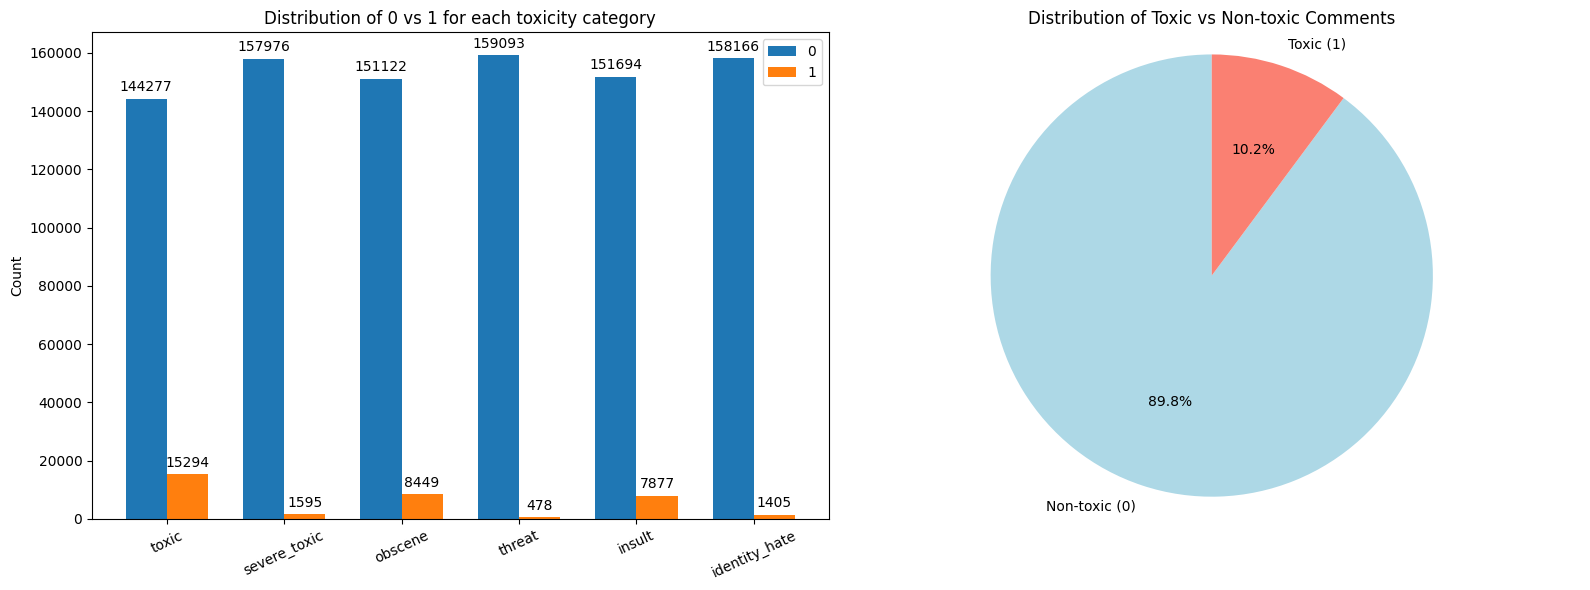

In [4]:
# Define the target label columns (as seen earlier)
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Ensure they exist
label_cols = [c for c in label_cols if c in df.columns]

# Compute counts for 0 and 1 for each label
counts = []
for c in label_cols:
    vc = df[c].value_counts().to_dict()
    counts.append({'label': c, 'count_0': vc.get(0, 0), 'count_1': vc.get(1, 0)})
counts_df = pd.DataFrame(counts).set_index('label')

# Replace the custom function with standard display
print("Counts (0 vs 1) for each label")
display(counts_df)

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot grouped bar chart on the left subplot
labels = counts_df.index.tolist()
count_0 = counts_df['count_0'].values
count_1 = counts_df['count_1'].values

x = np.arange(len(labels))
width = 0.35

# Bar chart on the left subplot
ax1.bar(x - width/2, count_0, width, label='0')
ax1.bar(x + width/2, count_1, width, label='1')
ax1.set_xticks(x)
ax1.set_xticklabels(labels, rotation=25)
ax1.set_ylabel('Count')
ax1.set_title('Distribution of 0 vs 1 for each toxicity category')
ax1.legend()

# Annotate counts on top of bars
for i in range(len(x)):
    ax1.text(x[i] - width/2, count_0[i] + max(count_0)*0.01, str(int(count_0[i])), ha='center', va='bottom')
    ax1.text(x[i] + width/2, count_1[i] + max(count_0)*0.01, str(int(count_1[i])), ha='center', va='bottom')

# Add pie chart for detect_toxic column on the right subplot
if 'detect_toxic' in df.columns:
    # Get value counts for detect_toxic column
    toxic_counts = df['detect_toxic'].value_counts()
    
    # Create labels and values for the pie chart
    pie_labels = ['Non-toxic (0)', 'Toxic (1)']
    sizes = [toxic_counts.get(0, 0), toxic_counts.get(1, 0)]
    
    # Create pie chart on the right subplot
    ax2.pie(sizes, labels=pie_labels, autopct='%1.1f%%', startangle=90, colors=['lightblue', 'salmon'])
    ax2.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
    ax2.set_title('Distribution of Toxic vs Non-toxic Comments')
    
    # Print the actual counts
    print(f"Non-toxic (0): {sizes[0]}")
    print(f"Toxic (1): {sizes[1]}")
else:
    ax2.text(0.5, 0.5, "Column 'detect_toxic' not found", ha='center', va='center')

plt.tight_layout()
plt.show()

# Pre Processing 

In this part I will try to clean my comment to get them ready for my model. 
First I will clean my text and then I will encode them 

## 1. Clean text

In [5]:
# I want to know the number of word in every comment to know the average
df["nb_mots"] = df["comment_text"].str.split().str.len()

# Average word
average_word = df['nb_mots'].mean()

# Dislpay
print('dataframe Shape :', df.shape)
print ('average word', average_word)
df.head()

dataframe Shape : (159571, 10)
average word 67.27352714465661


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,detect_toxic,nb_mots
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13


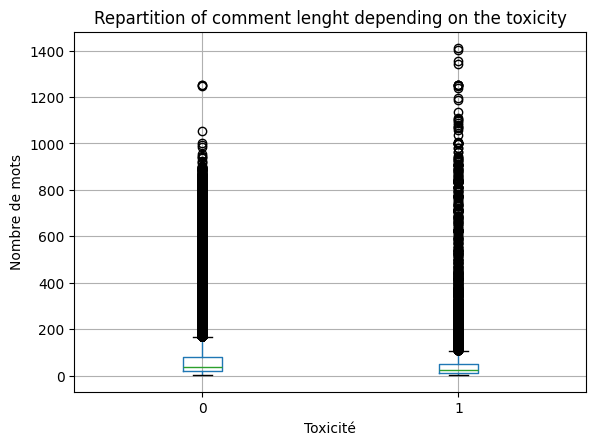

In [6]:
#test to check the relation between comment lenght and comment toxicity
df.boxplot(column="nb_mots", by="detect_toxic")
plt.title("Repartition of comment lenght depending on the toxicity")
plt.suptitle("")
plt.xlabel("Toxicité")
plt.ylabel("Nombre de mots")
plt.show()

In [7]:
# Pre-compiled regex patterns for performance
RE_URL = re.compile(r'https?://\S+|www\.\S+', flags=re.IGNORECASE)  # Detect URLs
RE_IP = re.compile(r'(([0-9]{1,3}\.){2,}[0-9]{1,3})')               # Detect IP addresses (basic IPv4 format)
RE_SYM_REPEAT = re.compile(r'([*!?.,;:()\[\]"\-—–])\1{2,}')         # Symbol repeated 3+ times
RE_LETTER_REPEAT = re.compile(r'([^\W\d_])\1{2,}', flags=re.UNICODE)  # Letter repeated 3+ times
RE_MULTI_SPACE = re.compile(r'\s{2,}')                              # Multiple spaces

def normalize_unicode(text):
    """
    Normalize unicode characters to a consistent representation (NFKC).
    This preserves accents while normalizing different forms of the same character.
    """
    return unicodedata.normalize('NFKC', text)

def clean_text_series(s: pd.Series,
                      lower: bool = True,
                      url_token: str = "[URL]",
                      ip_token: str = "[IP]",
                      max_letter_repeats: int = 2,
                      keep_sym_repeat_max: int = 3) -> pd.Series:
    """
    Clean a pandas Series of text efficiently using vectorized operations.

    Parameters:
    - lower: convert text to lowercase (disable for case-sensitive language models like BERT-base-cased)
    - url_token: token replacing detected URLs (keeps semantic value)
    - ip_token: token replacing detected IP addresses
    - max_letter_repeats: limit for character repetitions (e.g., "fuuuuck" → "fuuck" if set to 2)
    - keep_sym_repeat_max: limit for punctuation repetitions (e.g., "!!!!!" → "!!!")
    """

    s = s.astype(str).fillna("")   # Ensure text format + remove NaN
    s = s.map(normalize_unicode)   # Normalize unicode representation

    if lower:
        s = s.str.lower()

    # Replace URLs without adding extra whitespace
    s = s.str.replace(RE_URL, url_token, regex=True)

    # Replace IPs
    s = s.str.replace(RE_IP, ip_token, regex=True)

    # Remove newlines instead of replacing by token with spaces
    s = s.str.replace(r'\r\n|\r|\n', ' ', regex=True)

    # Reduce repeating punctuation marks
    def sym_repl(m):
        return m.group(1) * keep_sym_repeat_max
    s = s.str.replace(RE_SYM_REPEAT, lambda m: sym_repl(m), regex=True)

    # Reduce exaggerated letter repetitions
    if max_letter_repeats >= 1:
        def letter_repl(m):
            ch = m.group(1)
            return ch * max_letter_repeats
        s = s.str.replace(RE_LETTER_REPEAT, lambda m: letter_repl(m), regex=True)

    # Remove spacing rules around punctuation (no added spaces)
    
    # Replace emails with token
    s = s.str.replace(r'\b[\w\.-]+@[\w\.-]+\.\w{2,}\b', '[EMAIL]', regex=True)

    # Cleanup multiple spaces
    s = s.str.replace(RE_MULTI_SPACE, ' ', regex=True).str.strip()

    return s

In [8]:
# Create a small sample DataFrame to test the cleaning function
sample_data = {
    "comment_text": [
        "WTF!!!! This is soooo baaad... 😂😂😂 Check this out: https://example.com",
        "You are an IDIOT!!!!!!!",
        "Email me at test@example.com please!!!",
        "Fuuuuuuuck off!!! IP: 123.45.67.89",
        "Hello world :)",
        "No wayyyyyyy!!! WTF???",
        "Visit www.google.com now!!"
    ]
}

df_test = pd.DataFrame(sample_data)

df_test["clean_comment"] = clean_text_series(
    df_test["comment_text"],
    lower=True,
    url_token='[URL]',
    ip_token='[IP]',
    max_letter_repeats=2
)

df_test.head()

,comment_text,clean_comment
0,WTF!!!! This is soooo baaad... 😂😂😂 Check this ...,wtf!!! this is soo baad... 😂😂😂 check this out:...
1,You are an IDIOT!!!!!!!,you are an idiot!!!
2,Email me at test@example.com please!!!,email me at [EMAIL] please!!!
3,Fuuuuuuuck off!!! IP: 123.45.67.89,fuuck off!!! ip: [IP]
4,Hello world :),hello world :)


In [9]:
df_test['clean_comment'][0]

'wtf!!! this is soo baad... 😂😂😂 check this out: [URL]'

In [10]:
# Apply this to our dataset 
df["clean_comment"] = clean_text_series(
    df["comment_text"],
    lower=True,
    url_token='[URL]',
    ip_token='[IP]',
    max_letter_repeats=2
)

# I want to know the number of word aftrer clean the comment in every comment to know the average
df["nb_mots_clean"] = df["clean_comment"].str.split().str.len()

# Average word
average_word_cleaned = df['nb_mots_clean'].mean()

# Dislpay
print('dataframe Shape :', df.shape)
print ('average word', average_word_cleaned)
df.head()

dataframe Shape : (159571, 12)
average word 67.27745016325021


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,detect_toxic,nb_mots,clean_comment,nb_mots_clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,43,explanation why the edits made under my userna...,43
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,17,d'aww! he matches this background colour i'm s...,17
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,42,"hey man, i'm really not trying to edit war. it...",42
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,113,""" more i can't make any real suggestions on im...",113
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,13,"you, sir, are my hero. any chance you remember...",13


In [11]:
df['comment_text'][0]

"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27"

In [12]:
df['clean_comment'][0]

"explanation why the edits made under my username hardcore metallica fan were reverted? they weren't vandalisms, just closure on some gas after i voted at new york dolls fac. and please don't remove the template from the talk page since i'm retired now.[IP]"

## 2. Data Divide

In [15]:
# Use a balanced subset to speed up (sample up to 40000 rows, stratified on 'toxic')

max_samples = 40000
if df.shape[0] > max_samples:
    df_sub, _ = train_test_split(df, train_size=max_samples, stratify=df['detect_toxic'], random_state=42)
else:
    df_sub = df.copy()

texts = df_sub['comment_text'].astype(str).values
labels = df_sub['detect_toxic'].astype(int).values

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.15, stratify=labels, random_state=42)

print("Training samples:", len(X_train), "Validation samples:", len(X_val))
print("Positive rate in train:", y_train.mean(), "val:", y_val.mean())

Training samples: 34000 Validation samples: 6000
Positive rate in train: 0.1016764705882353 val: 0.10166666666666667


## 3. Encoding

In [16]:
# Text vectorization layer
max_tokens = 20000
sequence_length = 200
vectorize_layer = layers.TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(X_train)

## 4. Model

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_2            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_2 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 40s 73ms/step - accuracy: 0.8974 - auc: 0.5167 - loss: 0.3399 - val_accuracy: 0.8992 - val_auc: 0.5339 - val_loss: 0.3251
Epoch 2/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.9002 - auc: 0.5441 - loss: 0.3258 - val_accuracy: 0.8997 - val_auc: 0.5370 - val_loss: 0.3237
Epoch 3/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 43s 81ms/step - accuracy: 0.9017 - auc: 0.5515 - loss: 0.3205 - val_accuracy: 0.8998 - val_auc: 0.5370 - val_loss: 0.3272
Epoch 4/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 43s 80ms/step - accuracy: 0.9024 - auc: 0.5465 - loss: 0.3190 - val_accuracy: 0.9000 - val_auc: 0.5383 - val_loss: 0.3257
Epoch 5/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 52s 98ms/step - accuracy: 0.9321 - auc: 0.8677 - loss: 0.2124 - val_accuracy: 0.9535 - val_auc: 0.9530 - val_loss: 0.1373


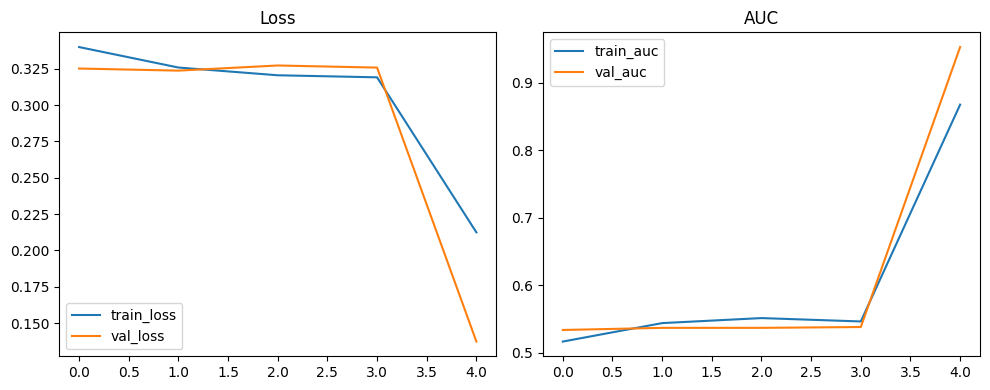

In [17]:
# Build model
embedding_dim = 128
model = keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

# Prepare datasets
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Train (small number of epochs)
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.legend(); plt.title('AUC')
plt.tight_layout()
plt.show()

## 5. Evaluation

In [18]:
# Evaluate on validation
eval_res = model.evaluate(val_ds, verbose=0)
eval_res_dict = dict(zip(model.metrics_names, eval_res))
print("Validation results:", eval_res_dict)

# Save model
model_save_path = "toxicity_model_partn.h5"
model.save(model_save_path, include_optimizer=False)
print("Model saved to:", model_save_path)

Validation results: {'loss': 0.13728612661361694, 'compile_metrics': 0.953499972820282}
Model saved to: toxicity_model_partn.h5


## 6. Test

In [19]:
samples = ["You are amazing!", "I will kill you", "What a stupid idea", "Thanks for your help :)"]
preds = model.predict(tf.constant(samples, dtype=tf.string))
print(preds)
for s,p in zip(samples,preds):
    print(f"{s[:60]:60} -> {p[0]:.4f}")

# Provide brief summary results
summary = {
    "train_samples": len(X_train),
    "val_samples": len(X_val),
    "epochs": epochs,
    "validation_metrics": eval_res_dict,
    "model_path": model_save_path
}
summary

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step
[[0.32065156]
 [0.9014033 ]
 [0.9055956 ]
 [0.0178576 ]]
You are amazing!                                             -> 0.3207
I will kill you                                              -> 0.9014
What a stupid idea                                           -> 0.9056
Thanks for your help :)                                      -> 0.0179


{'train_samples': 34000,
 'val_samples': 6000,
 'epochs': 5,
 'validation_metrics': {'loss': 0.13728612661361694,
  'compile_metrics': 0.953499972820282},
 'model_path': 'toxicity_model_partn.h5'}

Training samples: 34000 Validation samples: 6000
Positive rate in train: 0.1016764705882353 val: 0.10166666666666667


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization_1            │ (None, 200)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding_1 (Embedding)         │ (None, 200, 128)       │     2,560,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,667,137 (10.17 MB)

 Trainable params: 2,667,137 (10.17 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 39s 72ms/step - accuracy: 0.8981 - auc: 0.5056 - loss: 0.3409 - val_accuracy: 0.8985 - val_auc: 0.5331 - val_loss: 0.3245
Epoch 2/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.8995 - auc: 0.5328 - loss: 0.3280 - val_accuracy: 0.8995 - val_auc: 0.5323 - val_loss: 0.3279
Epoch 3/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.9014 - auc: 0.5458 - loss: 0.3221 - val_accuracy: 0.8997 - val_auc: 0.5356 - val_loss: 0.3261
Epoch 4/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.9005 - auc: 0.5462 - loss: 0.3353 - val_accuracy: 0.8998 - val_auc: 0.5372 - val_loss: 0.3261
Epoch 5/5
532/532 ━━━━━━━━━━━━━━━━━━━━ 44s 82ms/step - accuracy: 0.9199 - auc: 0.6704 - loss: 0.2749 - val_accuracy: 0.9177 - val_auc: 0.6290 - val_loss: 0.2885


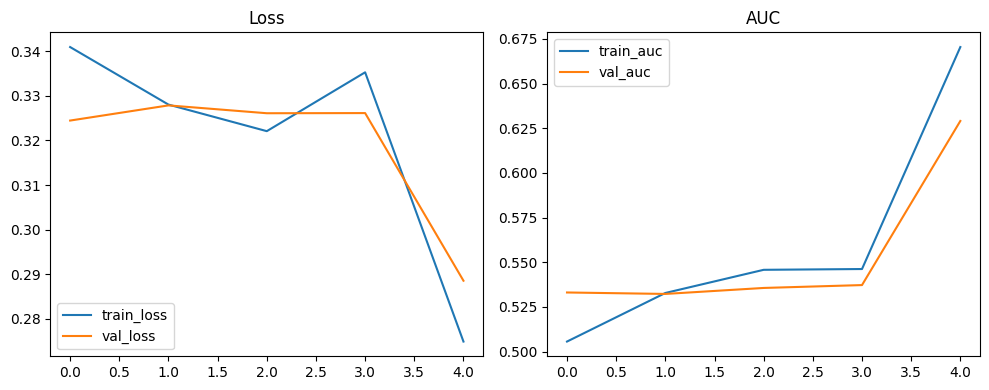

Validation results: {'loss': 0.28852686285972595, 'compile_metrics': 0.9176666736602783}
Model saved to: toxicity_model_small.h5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
[[0.1004514 ]
 [0.1004514 ]
 [0.8939684 ]
 [0.10045142]]
You are amazing!                                             -> 0.1005
I will kill you                                              -> 0.1005
What a stupid idea                                           -> 0.8940
Thanks for your help :)                                      -> 0.1005


{'train_samples': 34000,
 'val_samples': 6000,
 'epochs': 5,
 'validation_metrics': {'loss': 0.28852686285972595,
  'compile_metrics': 0.9176666736602783},
 'model_path': 'toxicity_model_small.h5'}

In [14]:
# Building and training a Keras model to predict 'toxic' using a subset for speed
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Use a balanced subset to speed up (sample up to 40000 rows, stratified on 'toxic')
max_samples = 40000
if df.shape[0] > max_samples:
    df_sub, _ = train_test_split(df, train_size=max_samples, stratify=df['detect_toxic'], random_state=42)
else:
    df_sub = df.copy()

texts = df_sub['comment_text'].astype(str).values
labels = df_sub['detect_toxic'].astype(int).values

# Train/validation split
X_train, X_val, y_train, y_val = train_test_split(texts, labels, test_size=0.15, stratify=labels, random_state=42)

print("Training samples:", len(X_train), "Validation samples:", len(X_val))
print("Positive rate in train:", y_train.mean(), "val:", y_val.mean())

# Text vectorization layer
max_tokens = 20000
sequence_length = 200
vectorize_layer = layers.TextVectorization(max_tokens=max_tokens, output_mode='int', output_sequence_length=sequence_length)
vectorize_layer.adapt(X_train)

# Build model
embedding_dim = 128
model = keras.Sequential([
    layers.Input(shape=(1,), dtype=tf.string),
    vectorize_layer,
    layers.Embedding(input_dim=max_tokens, output_dim=embedding_dim, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64, return_sequences=False)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])
model.summary()

# Prepare datasets
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(10000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Train (small number of epochs)
epochs = 5
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs)

# Plot training curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend(); plt.title('Loss')
plt.subplot(1,2,2)
plt.plot(history.history['auc'], label='train_auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.legend(); plt.title('AUC')
plt.tight_layout()
plt.show()

# Evaluate on validation
eval_res = model.evaluate(val_ds, verbose=0)
eval_res_dict = dict(zip(model.metrics_names, eval_res))
print("Validation results:", eval_res_dict)

# Save model
model_save_path = "toxicity_model_small.h5"
model.save(model_save_path, include_optimizer=False)
print("Model saved to:", model_save_path)

# Show a few predictions
samples = ["You are amazing!", "I will kill you", "What a stupid idea", "Thanks for your help :)"]
preds = model.predict(tf.constant(samples, dtype=tf.string))
print(preds)
for s,p in zip(samples,preds):
    print(f"{s[:60]:60} -> {p[0]:.4f}")

# Provide brief summary results
summary = {
    "train_samples": len(X_train),
    "val_samples": len(X_val),
    "epochs": epochs,
    "validation_metrics": eval_res_dict,
    "model_path": model_save_path
}
summary